## Applying scikit-learn's Logistic Regression, Naive Bayes Classifier, KNN Classifier, MLP Classifier, Decision Tree Classifier, Random Forest Classifier and XGBoost to the Car Evaluation Dataset
## 1: Setup
### 1.1: Importing Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

### 1.2 Reading the data:

In [2]:
col_names = ['buyPrice', 'maintCost', 'noDoors', 'noPersons', 'bootLuggage', 'safety', 'decision']
path = "../input/car-evaluation-data-set/car_evaluation.csv"
car_data = pd.read_csv(path, header = 0, names = col_names)

print(car_data.shape)
car_data.head()

(1727, 7)


,buyPrice,maintCost,noDoors,noPersons,bootLuggage,safety,decision
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


Hence, we see that there are 1727 rows and 7 feature columns.

In [3]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   buyPrice     1727 non-null   object
 1   maintCost    1727 non-null   object
 2   noDoors      1727 non-null   object
 3   noPersons    1727 non-null   object
 4   bootLuggage  1727 non-null   object
 5   safety       1727 non-null   object
 6   decision     1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


We can check the frequency count of the labels in the categorical variables:

In [4]:
for col in col_names:
    
    print(car_data[col].value_counts())   

high     432
med      432
low      432
vhigh    431
Name: buyPrice, dtype: int64
high     432
med      432
low      432
vhigh    431
Name: maintCost, dtype: int64
3        432
4        432
5more    432
2        431
Name: noDoors, dtype: int64
4       576
more    576
2       575
Name: noPersons, dtype: int64
med      576
big      576
small    575
Name: bootLuggage, dtype: int64
med     576
high    576
low     575
Name: safety, dtype: int64
unacc    1209
acc       384
good       69
vgood      65
Name: decision, dtype: int64


Tallying up the total for each feature results in the number of rows: 1727, so there are no null values. We can check again with:

In [5]:
car_data.isnull().sum()

buyPrice       0
maintCost      0
noDoors        0
noPersons      0
bootLuggage    0
safety         0
decision       0
dtype: int64

So, there are no null values in the dataset.

## 2: Exploratory Data Analysis
### 2.1: Encoding Categorical Features
Since some of our features are categorical, we must encode them to integer form:

In [6]:
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=['buyPrice', 'maintCost', 'noDoors', 'noPersons', 'bootLuggage', 'safety'])

car_data = encoder.fit_transform(car_data)

print(car_data.head())
car_data.head()

   buyPrice  maintCost  noDoors  noPersons  bootLuggage  safety decision
0         1          1        1          1            1       1    unacc
1         1          1        1          1            1       2    unacc
2         1          1        1          1            2       3    unacc
3         1          1        1          1            2       1    unacc
4         1          1        1          1            2       2    unacc


,buyPrice,maintCost,noDoors,noPersons,bootLuggage,safety,decision
0,1,1,1,1,1,1,unacc
1,1,1,1,1,1,2,unacc
2,1,1,1,1,2,3,unacc
3,1,1,1,1,2,1,unacc
4,1,1,1,1,2,2,unacc


### 2.2 Summary stats

In [7]:
car_data.describe().round(2)

,buyPrice,maintCost,noDoors,noPersons,bootLuggage,safety
count,1727.00,1727.00,1727.00,1727.00,1727.00,1727.00
mean,2.50,2.50,2.50,2.00,2.00,2.00
std,1.12,1.12,1.12,0.82,0.82,0.82
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,1.00,1.00,1.00
50%,3.00,3.00,3.00,2.00,2.00,2.00
75%,3.50,3.50,3.50,3.00,3.00,3.00
max,4.00,4.00,4.00,3.00,3.00,3.00


### 2.3: Univariate histogram plots (feature data distribution)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'buyPrice'}>,
        <AxesSubplot:title={'center':'maintCost'}>],
       [<AxesSubplot:title={'center':'noDoors'}>,
        <AxesSubplot:title={'center':'noPersons'}>],
       [<AxesSubplot:title={'center':'bootLuggage'}>,
        <AxesSubplot:title={'center':'safety'}>]], dtype=object)

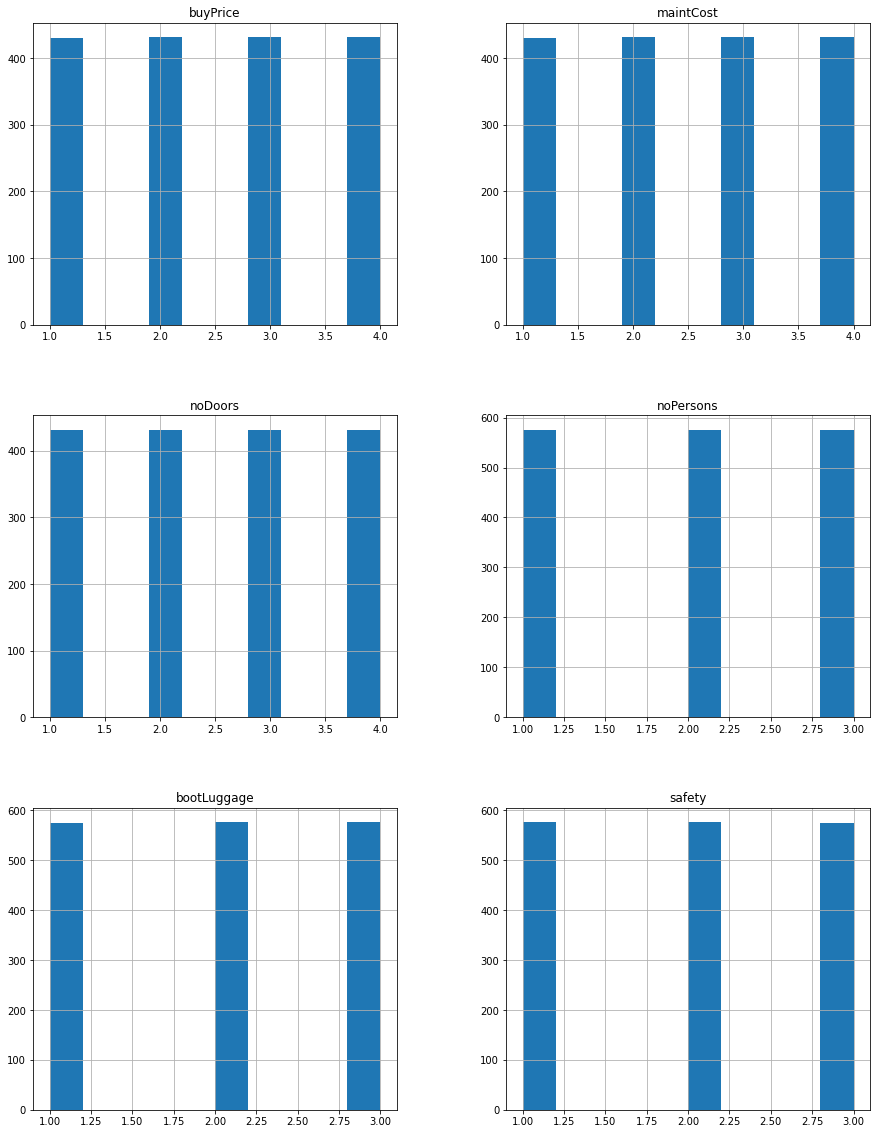

In [8]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
car_data.hist(ax = ax)

As we can see, all of the features (except the target feature 'decision') are evenly distributed.
This means that when we train the data, we should use a stratified k-fold cross-validation to ensure that there are an even number of samples in the test set. 

### 2.4: Correlation Matrix

<AxesSubplot:>

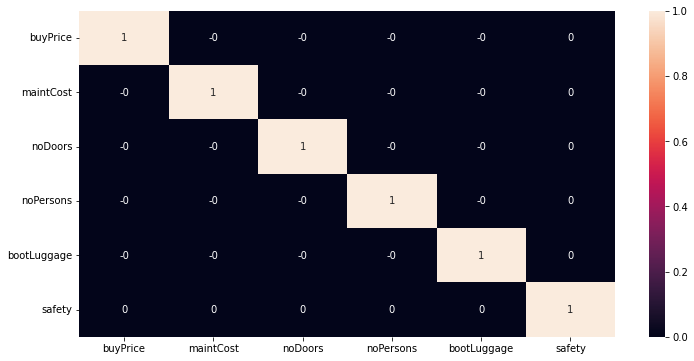

In [9]:
corr_matrix = car_data.corr().round(2)
plt.figure(figsize = (12, 6))
sns.heatmap(corr_matrix, annot = True)

None of our features show a strong linear correlation to the data: the column with the greatest absolute correlation coefficient value is noPersons at r = 0.34.
Thus, logistic regression will not help us much here. We should look for nonlinear relations for our model.

### 2.5 Splitting training and target features
First, we declare our target variable and our feature set:

In [10]:
X = car_data.drop(['decision'], axis=1)

y = car_data['decision']

X.head()

,buyPrice,maintCost,noDoors,noPersons,bootLuggage,safety
0,1,1,1,1,1,1
1,1,1,1,1,1,2
2,1,1,1,1,2,3
3,1,1,1,1,2,1
4,1,1,1,1,2,2


Now we normalize our target features

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X[X.columns] = scaler.fit_transform(X[X.columns])

print(X.head())
y[:5]

   buyPrice  maintCost  noDoors  noPersons  bootLuggage  safety
0       0.0        0.0      0.0        0.0          0.0     0.0
1       0.0        0.0      0.0        0.0          0.0     0.5
2       0.0        0.0      0.0        0.0          0.5     1.0
3       0.0        0.0      0.0        0.0          0.5     0.0
4       0.0        0.0      0.0        0.0          0.5     0.5


0    unacc
1    unacc
2    unacc
3    unacc
4    unacc
Name: decision, dtype: object

Now we are ready to instantiate and train the model.

## 3: Logistic Regression

### 3.1: Instantiation

In [12]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()

### 3.2: Training

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {'penalty': ['l2', 'none'],
              'max_iter': [100, 200, 300, 400, 500]
             }

# use gridsearch to do 5-fold cross validation
lgr_gscv = GridSearchCV(lgr, param_grid, cv = 5)


lgr_gscv.fit(X, y)
lgr_gscv.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'max_iter': 100, 'penalty': 'l2'}

### 3.3: Testing

We can now get the best score from the model:

In [14]:
lgr_gscv.best_score_

0.6977381251570748

So, we have a model with an accuracy of 70%.

## 4: Naive Bayes Classifier

Because our target variable has more than 2 labels, we must use a Multinomial Naive Bayes Classifier

### 4.1: Instantiation

In [15]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

### 4.2: Training

In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = {}

# use gridsearch to do 5-fold cross validation
mnb_gscv = GridSearchCV(mnb, param_grid, cv = 5)


mnb_gscv.fit(X, y)

GridSearchCV(cv=5, estimator=MultinomialNB(), param_grid={})

### 4.3: Testing

We can now get the best score from the model:

In [17]:
mnb_gscv.best_score_

0.7000586411996315

So, we have a model with an accuracy of 70%.

## 5: KNN (K-Nearest Neighbours)

### 5.1: Instantiation

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

### 5.2: Training

In [19]:
param_grid = {'n_neighbors': np.arange(2, 10)}

# use gridsearch to do 5-fold cross validation
knn_gscv = GridSearchCV(knn, param_grid, cv = 5)


knn_gscv.fit(X, y)

knn_gscv.best_estimator_

KNeighborsClassifier(n_neighbors=7)

### 5.3: Testing

We can now get the best score from the model:

In [20]:
knn_gscv.best_score_

0.9224344475161264

So, we have a model with an accuracy of 92%.

## 6: MLP (Multi-Layer Perceptron)

### 6.1: Instantiation

In [21]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter = 700, random_state = 1)

### 6.2: Training

In [22]:
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
              'activation': ['relu','tanh','logistic'],
              'learning_rate': ['constant','adaptive'],
              'solver': ['adam', 'sgd']}

mlp_gscv = GridSearchCV(
    mlp,
    param_grid,
    cv=5, verbose=0, n_jobs=-1)

mlp_gscv.fit(X, y)


mlp_gscv.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multi

{'activation': 'relu',
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'solver': 'adam'}

### 6.3: Testing

We can now get the best score from the model:

In [23]:
mlp_gscv.best_score_

0.9385909357459999

So, we have a model with an accuracy of 94%.

## 7: Decision Tree Classifier

### 7.1: Instantiation

In [24]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 1)

### 7.2: Training

In [25]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [3, 5, 7, 10]}

dt_gscv = GridSearchCV(
    dt,
    param_grid,
    cv=5, verbose=0, n_jobs=-1)

dt_gscv.fit(X, y)


dt_gscv.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_mess

{'criterion': 'entropy', 'max_depth': 10}

### 7.3: Testing

We can now get the best score from the model:

In [26]:
dt_gscv.best_score_

0.838508838066516

So, we have a model with an accuracy of 84%.

## 8: Random Forest Classifier

### 8.1: Instantiation

In [27]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=700, random_state = 1, n_jobs = -1)

### 8.2: Training

In [28]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [3, 5, 7, 10]}

random_forest_gscv = GridSearchCV(
    random_forest,
    param_grid,
    cv=5, verbose=0, n_jobs=-1)

random_forest_gscv.fit(X, y)


random_forest_gscv.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 933, in

{'criterion': 'entropy', 'max_depth': 10}

### 8.3: Testing

We can now get the best score from the model:

In [29]:
random_forest_gscv.best_score_

0.8431448437630896

So, we have a model with an accuracy of 84%.

## 9: XGBoosted Random Forest

### 9.1: Instantiation

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_xgb = le.fit_transform(y)


from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000, random_state = 1)

### 9.2: Training

In [31]:
param_grid = {
    'eta': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 0.9],
    'learning_rate': [0.05, 0.1, 0.3],
}

from sklearn.model_selection import GridSearchCV
xgb_gscv = GridSearchCV(
    xgb,
    param_grid,
    cv=5, verbose=0, n_jobs=-1)

xgb_gscv.fit(X, y_xgb)
xgb_gscv.best_params_

{'eta': 0.05, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.7}

### 9.3: Testing

We can now get the best score from the model:

In [32]:
xgb_gscv.best_score_

0.843655859931306

So, we have a model with an accuracy of 84%.